# Todo

* Do the experiment over several random seeds
* Plot everything in the same axis
* done -- Use the pytorch RNN cell to get the same result
* done -- Play with the hidden size
* done -- Only finetune on the new data
* done -- Use MAE to compute the test loss
* done -- play with the sampling frequency

In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from collections import namedtuple

In [2]:
def generate_sequence(c=0.005, f_0=0, sf=10):
    """
    Generate a linear chirp. x is the time-domain signal and f is the instantaneous frequency
    """
    t = np.arange(0, 50, 1/sf)
    f = c * t + f_0
    phi = 2 * np.pi * (c / 2 * t**2 + f_0 * t)
    x = np.sin(phi)
    return x, f, t

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [22]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNCell, self).__init__()
        self.hidden_size = hidden_size

        # Input to hidden
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # Hidden to output
        self.h2o = nn.Linear(hidden_size, output_size)
        self.activation = nn.Tanh()

        # self.initialize_weights()

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h_next = self.activation(self.i2h(combined))
        output = self.h2o(h_next)
        return output, h_next

    def initialize_weights(self):
        for layer in [self.i2h, self.h2o]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

In [23]:
def train_rnn(rnn, data, t, t_pretrain, hp, ignore_pretrained_data=False):
    # train the RNN on the first t steps of the sequence
    X, Y = data
    input_seq, output_seq = X[:t], Y[:t]
    len_seq = len(input_seq)

    rnn.train()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=hp.lr)
    criterion = nn.MSELoss(reduction='none')
    pbar = tqdm(range(hp.num_epochs))

    for epoch in pbar:
        # initialize hidden state
        h = torch.zeros(1, rnn.hidden_size)
        
        # iterate over the sequence
        outs = []
        ys = []
        for k in range(len_seq):
            x = torch.tensor(input_seq[k]).view(1, -1).float()
            y = torch.tensor(output_seq[k]).view(1).float()
            out, h = rnn(x, h)
            outs.append(out)
            ys.append(y)
        outs = torch.stack(outs).squeeze()
        ys = torch.stack(ys).squeeze()
        
        # compute loss
        unmasked_losses = criterion(outs, ys)
        if ignore_pretrained_data:
            mask = torch.zeros_like(unmasked_losses, dtype=torch.bool)
            mask[t_pretrain:] = True
            masked_losses = unmasked_losses * mask.float()
            loss = masked_losses.mean()
        else:
            loss = unmasked_losses.mean()

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1}/{hp.num_epochs}, Loss: {loss.item()/len_seq:.4f}")
    return rnn

def evaluate(rnn, data, t):
    # get data (only evaluate on the future, beyond t)
    X, Y = data
    input_seq, output_seq = X, Y

    rnn.eval()
    with torch.no_grad():
        h = torch.zeros(1, rnn.hidden_size)
        loss = []
        for k in range(len(input_seq)):
            x = torch.tensor(input_seq[k]).view(1, -1).float()
            y = torch.tensor(output_seq[k]).view(1).float()
            out, h = rnn(x, h)
            loss.append((out.squeeze() - y).abs().detach().numpy()) # MAE
    return np.mean(loss[t:])

def pretrain(data, t, hp, sample_rate, seed=1996):
    """
    pretrain the RNN on the first t steps of the sequence
    """
    t = int(t * sample_rate)

    # initialize
    set_seed(seed)
    rnn = RNNCell(1, hp.hidden_size, 1)

    if t > 0:
        rnn = train_rnn(rnn, data, t, t, hp, ignore_pretrained_data=False)
    error = evaluate(rnn, data, t)
    return rnn.state_dict(), error

def run_at_time(data, t, t_pretrain, pretrained_state_dict, hp, sample_rate, ignore_pretrained_data=False, finetune=True, seed=1996):
    """
    We train an RNN to predict the instantaneous frequency in the future, given the time-domain value and the previous state.

    The RNN pretrained on the first `t_pretrain` steps of the sequence.

    When train == True: 
        The RNN is trained on the first t (including the pretraining data) steps of the sequence and evaluated on the future steps

    When train == False
        The RNN is not trained at all (no gradient steps)    
    """
    t = int(t * sample_rate)
    t_pretrain = int(t_pretrain * sample_rate)

    # initialize
    set_seed(seed)
    rnn = RNNCell(1, hp.hidden_size, 1)
    rnn.load_state_dict(pretrained_state_dict)

    # train
    if finetune:
        rnn = train_rnn(rnn, data, t, t_pretrain, hp, ignore_pretrained_data=ignore_pretrained_data)

    # evaluate
    error = evaluate(rnn, data, t)
    
    return error

In [24]:
sample_rate = 10
hidden_size = 8

lr_pretrain = 0.001
num_epochs_pretrain = 100

lr_finetune = 0.001
num_epochs_finetune = 100

t_pretrain = 10
t_list = np.arange(10+1, 25, 1)

Hyperparameters = namedtuple('Hyperparameters', ['hidden_size', 'lr', 'num_epochs'])
hp_pretrain = Hyperparameters(hidden_size=hidden_size, lr=lr_pretrain, num_epochs=num_epochs_pretrain)
hp_finetune = Hyperparameters(hidden_size=hidden_size, lr=lr_finetune, num_epochs=num_epochs_finetune)

In [25]:
X, Y, _ = generate_sequence(sf=sample_rate)

In [26]:
err_ft_list = []
err_noft_list = []

pretrained_state_dict, initial_error = pretrain((X, Y), t_pretrain, hp_pretrain, sample_rate)

for t in t_list:
    print(f"t = {t}")
    err = run_at_time((X, Y), t, t_pretrain, pretrained_state_dict, hp_finetune, sample_rate, ignore_pretrained_data=False, finetune=True)
    err_ft_list.append(err)

    err = run_at_time((X, Y), t, t_pretrain, pretrained_state_dict, hp_finetune, sample_rate, ignore_pretrained_data=False, finetune=False)
    err_noft_list.append(err)

Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 23.15it/s]


t = 11


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


t = 12


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 17.56it/s]


t = 13


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 17.69it/s]


t = 14


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 17.11it/s]


t = 15


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:07<00:00, 13.33it/s]


t = 16


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 17.87it/s]


t = 17


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:06<00:00, 15.29it/s]


t = 18


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 16.86it/s]


t = 19


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:06<00:00, 15.57it/s]


t = 20


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:07<00:00, 13.58it/s]


t = 21


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:07<00:00, 13.21it/s]


t = 22


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:07<00:00, 13.48it/s]


t = 23


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:08<00:00, 11.36it/s]


t = 24


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:10<00:00,  9.15it/s]


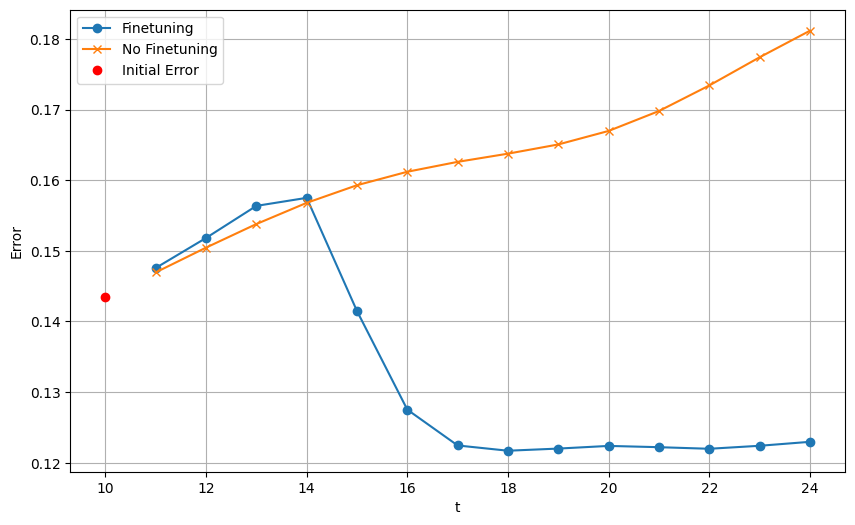

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(t_list, err_ft_list, label='Finetuning', marker='o')
plt.plot(t_list, err_noft_list, label='No Finetuning', marker='x')
plt.plot([t_pretrain], [initial_error], 'ro', label='Initial Error')
plt.xlabel('t')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

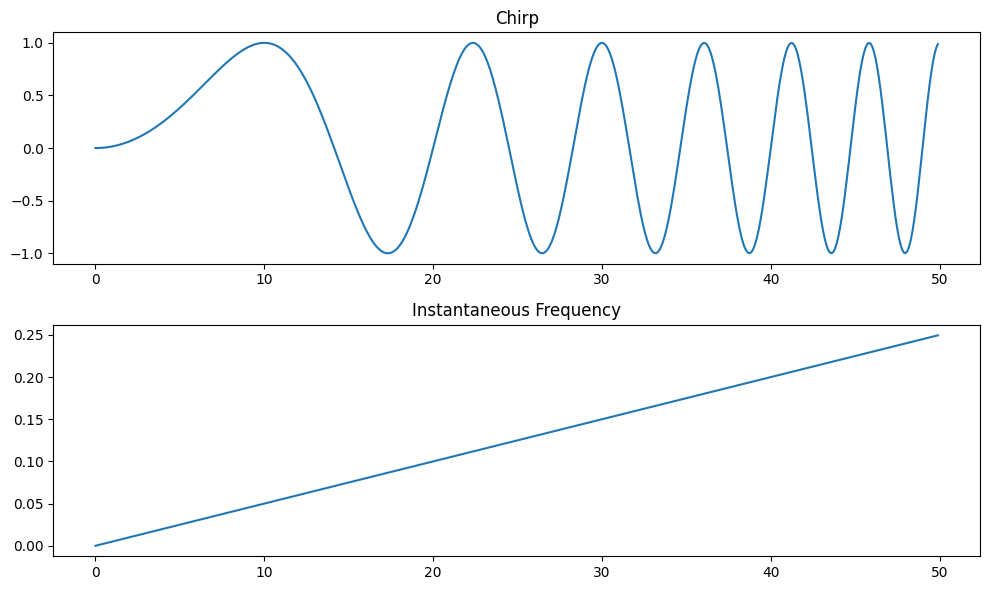

In [35]:
# plot the generated signal
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
X, Y, T = generate_sequence(sf=sample_rate)
ax[0].plot(T, X)
ax[0].set_title('Chirp')
ax[1].plot(T, Y)
ax[1].set_title('Instantaneous Frequency')
fig.tight_layout()
plt.show()

## Using PyTorch RNN

Anything wrong here?

In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from collections import namedtuple
from torch.nn import RNN

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
def generate_sequence(c=0.005, f_0=0, sf=10):
    """
    Generate a linear chirp. x is the time-domain signal and f is the instantaneous frequency
    """
    t = np.arange(0, 50, 1/sf)
    f = c * t + f_0
    phi = 2 * np.pi * (c / 2 * t**2 + f_0 * t)
    x = np.sin(phi)
    return x, f, t

In [4]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNCell, self).__init__()
        self.hidden_size = hidden_size

        self.rnn = RNN(input_size, hidden_size, batch_first=True)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h, _ = self.rnn(x)
        output = self.h2o(h)
        return output

In [5]:
def train_rnn(rnn, data, t, t_pretrain, hp, ignore_pretrained_data=False):
    # train the RNN on the first t steps of the sequence
    X, Y = data
    input_seq, output_seq = X[:t], Y[:t]
    len_seq = len(input_seq)

    x = torch.from_numpy(input_seq).view(1, -1, 1).float()
    y = torch.from_numpy(output_seq).float()

    rnn.train()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=hp.lr)
    criterion = nn.MSELoss(reduction='none')
    pbar = tqdm(range(hp.num_epochs))

    for epoch in pbar:    
        # iterate over the sequence
        out = rnn(x)
        
        # compute loss
        unmasked_losses = criterion(out.squeeze(), y)
        if ignore_pretrained_data:
            mask = torch.zeros_like(unmasked_losses, dtype=torch.bool)
            mask[t_pretrain:] = True
            masked_losses = unmasked_losses * mask.float()
            loss = masked_losses.mean()
        else:
            loss = unmasked_losses.mean()

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1}/{hp.num_epochs}, Loss: {loss.item()/len_seq:.4f}")
    return rnn

def evaluate(rnn, data, t):
    # get data (only evaluate on the future, beyond t)
    X, Y = data
    input_seq, output_seq = X, Y

    x = torch.from_numpy(input_seq).view(1, -1, 1).float()
    y = torch.from_numpy(output_seq).float()

    rnn.eval()
    with torch.no_grad():
        out = rnn(x)
        unmasked_losses = (out.squeeze() - y).abs().detach().numpy()
    return np.mean(unmasked_losses[t:])

def pretrain(data, t, hp, sample_rate, seed=1996):
    """
    pretrain the RNN on the first t steps of the sequence
    """
    t = int(t * sample_rate)

    # initialize
    set_seed(seed)
    rnn = RNNCell(1, hp.hidden_size, 1)

    if t > 0:
        rnn = train_rnn(rnn, data, t, t, hp, ignore_pretrained_data=False)
    error = evaluate(rnn, data, t)
    return rnn.state_dict(), error

def run_at_time(data, t, t_pretrain, pretrained_state_dict, hp, sample_rate, ignore_pretrained_data=False, finetune=True, seed=1996):
    """
    We train an RNN to predict the instantaneous frequency in the future, given the time-domain value and the previous state.

    The RNN pretrained on the first `t_pretrain` steps of the sequence.

    When train == True: 
        The RNN is trained on the first t (including the pretraining data) steps of the sequence and evaluated on the future steps

    When train == False
        The RNN is not trained at all (no gradient steps)    
    """
    t = int(t * sample_rate)
    t_pretrain = int(t_pretrain * sample_rate)

    # initialize
    set_seed(seed)
    rnn = RNNCell(1, hp.hidden_size, 1)
    rnn.load_state_dict(pretrained_state_dict)

    # train
    if finetune:
        rnn = train_rnn(rnn, data, t, t_pretrain, hp, ignore_pretrained_data=ignore_pretrained_data)

    # evaluate
    error = evaluate(rnn, data, t)
    
    return error

In [6]:
def run_on_seed(
        data, 
        t_pretrain, 
        t_list, 
        hp_pretrain, 
        hp_finetune, 
        sample_rate, 
        ignore_pretrained_data=False,
        seed=1996
    ):
    
    err_ft_list = []
    err_noft_list = []

    pretrained_state_dict, initial_error = pretrain(data, t_pretrain, hp_pretrain, sample_rate, seed=seed)

    for t in t_list:
        print(f"t = {t}")
        err = run_at_time(data, t, t_pretrain, pretrained_state_dict, hp_finetune, sample_rate, ignore_pretrained_data=ignore_pretrained_data, finetune=True, seed=seed)
        err_ft_list.append(err)

        err = run_at_time(data, t, t_pretrain, pretrained_state_dict, hp_finetune, sample_rate, ignore_pretrained_data=ignore_pretrained_data, finetune=False, seed=seed)
        err_noft_list.append(err)

    return err_ft_list, err_noft_list, initial_error

In [18]:
sample_rate = 10
hidden_size = 8
ignore_pretrained_data = False
num_reps = 3

lr_pretrain = 0.001
num_epochs_pretrain = 100

lr_finetune = 0.001
num_epochs_finetune = 100

t_pretrain = 10
t_list = np.arange(10+1, 25, 1)

Hyperparameters = namedtuple('Hyperparameters', ['hidden_size', 'lr', 'num_epochs'])
hp_pretrain = Hyperparameters(hidden_size=hidden_size, lr=lr_pretrain, num_epochs=num_epochs_pretrain)
hp_finetune = Hyperparameters(hidden_size=hidden_size, lr=lr_finetune, num_epochs=num_epochs_finetune)

In [19]:
X, Y, _ = generate_sequence(sf=sample_rate)

In [25]:
err_ft = []
err_noft = []
err_init = []

for _ in range(num_reps):
    # seed = random.randint(0, 10000)
    errs = run_on_seed(
        (X, Y), 
        t_pretrain, 
        t_list, 
        hp_pretrain, 
        hp_finetune, 
        sample_rate, 
        ignore_pretrained_data=ignore_pretrained_data,
        seed=1996
    )
    err_ft.append(errs[0])
    err_noft.append(errs[1])
    err_init.append(errs[2])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:01<00:00, 83.08it/s]


t = 11


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:01<00:00, 74.15it/s]


t = 12


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:01<00:00, 65.20it/s]


t = 13


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 46.07it/s]


t = 14


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 43.23it/s]


t = 15


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 31.96it/s]


t = 16


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 36.29it/s]


t = 17


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 29.73it/s]


t = 18


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 27.68it/s]


t = 19


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 29.64it/s]


t = 20


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 23.56it/s]


t = 21


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 21.91it/s]


t = 22


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 24.23it/s]


t = 23


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 22.83it/s]


t = 24


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:01<00:00, 69.33it/s]


t = 11


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:01<00:00, 76.50it/s]


t = 12


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:01<00:00, 63.86it/s]


t = 13


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 46.08it/s]


t = 14


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 45.38it/s]


t = 15


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 29.42it/s]


t = 16


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 30.56it/s]


t = 17


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 38.95it/s]


t = 18


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 33.78it/s]


t = 19


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 26.13it/s]


t = 20


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 25.72it/s]


t = 21


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 23.98it/s]


t = 22


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 23.87it/s]


t = 23


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 21.92it/s]


t = 24


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:01<00:00, 82.93it/s]


t = 11


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:01<00:00, 69.13it/s]


t = 12


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:01<00:00, 66.70it/s]


t = 13


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 38.43it/s]


t = 14


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 38.00it/s]


t = 15


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 40.30it/s]


t = 16


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 41.29it/s]


t = 17


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 36.86it/s]


t = 18


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 40.13it/s]


t = 19


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 31.34it/s]


t = 20


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 27.90it/s]


t = 21


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 27.71it/s]


t = 22


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 23.66it/s]


t = 23


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 24.26it/s]


t = 24


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


In [28]:
err_ft_mean = np.mean(err_ft, axis=0)
err_noft_mean = np.mean(err_noft, axis=0)
err_init_mean = np.mean(err_init, axis=0)

err_ft_std = np.std(err_ft, axis=0)
err_noft_std = np.std(err_noft, axis=0)
err_init_std = np.std(err_init, axis=0)

# Calculate 95% confidence interval for error bars
z_score = 1.96
err_ft_margin = z_score * err_ft_std / np.sqrt(len(err_ft))
err_noft_margin = z_score * err_noft_std / np.sqrt(len(err_noft))

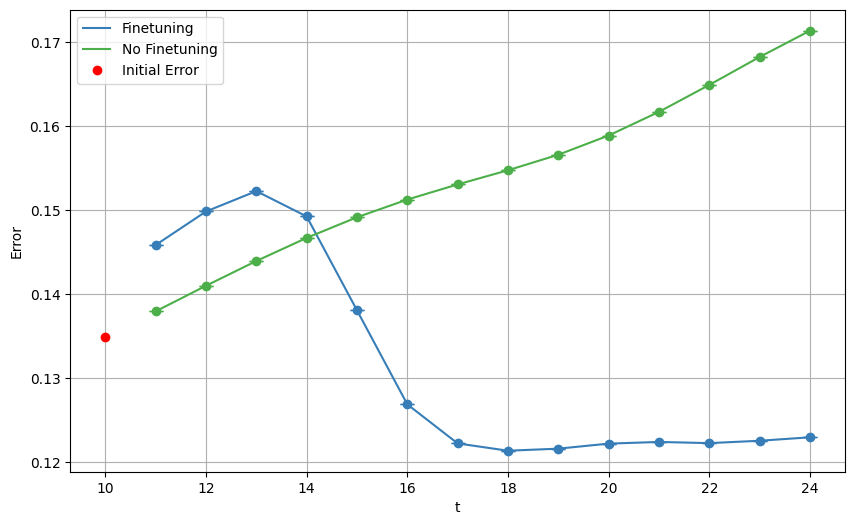

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))

color = '#377eb8'
ax.plot(t_list, err_ft_mean, label='Finetuning', color=color)
ax.errorbar(t_list, err_ft_mean, yerr=err_ft_margin, fmt='o', capsize=5, color=color)

color = '#4daf4a'
ax.plot(t_list, err_noft_mean, label='No Finetuning', color=color)
ax.errorbar(t_list, err_noft_mean, yerr=err_noft_margin, fmt='o', capsize=5, color=color)


ax.plot([t_pretrain], [err_init_mean], 'ro', label='Initial Error')

ax.set_xlabel('t')
ax.set_ylabel('Error')
ax.legend()
ax.grid(True)
plt.show()

In [24]:
err_init

[np.float32(0.13944052), np.float32(0.09663317), np.float32(0.13812982)]

In [114]:
X, Y, _ = generate_sequence(sf=sample_rate)

In [115]:
err_ft_list = []
err_noft_list = []

pretrained_state_dict, initial_error = pretrain((X, Y), t_pretrain, hp_pretrain, sample_rate)

for t in t_list:
    print(f"t = {t}")
    err = run_at_time((X, Y), t, t_pretrain, pretrained_state_dict, hp_finetune, sample_rate, ignore_pretrained_data=False, finetune=True)
    err_ft_list.append(err)

    err = run_at_time((X, Y), t, t_pretrain, pretrained_state_dict, hp_finetune, sample_rate, ignore_pretrained_data=False, finetune=False)
    err_noft_list.append(err)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 20.18it/s]


t = 11


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 41.76it/s]


t = 12


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 38.72it/s]


t = 13


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


t = 14


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 17.10it/s]


t = 15


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 18.48it/s]


t = 16


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


t = 17


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 17.37it/s]


t = 18


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


t = 19


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:11<00:00,  9.00it/s]


t = 20


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:13<00:00,  7.63it/s]


t = 21


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


t = 22


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


t = 23


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:23<00:00,  4.24it/s]


t = 24


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


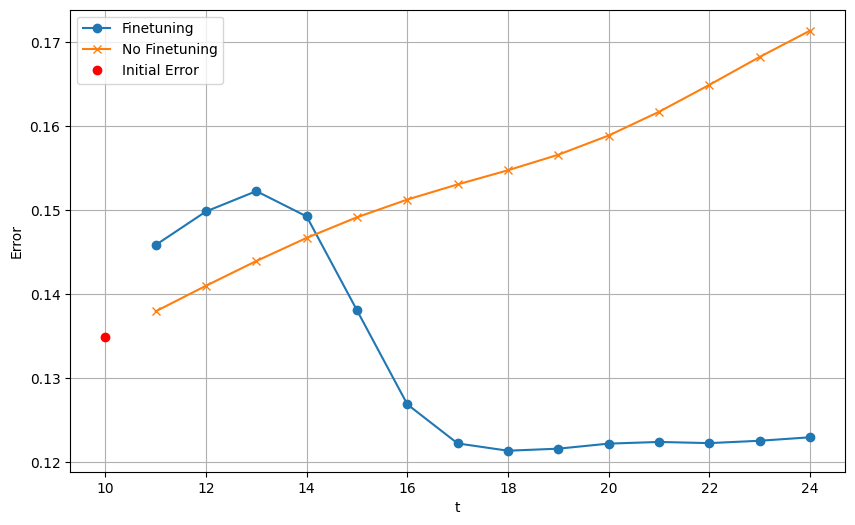

In [116]:
plt.figure(figsize=(10, 6))
plt.plot(t_list, err_ft_list, label='Finetuning', marker='o')
plt.plot(t_list, err_noft_list, label='No Finetuning', marker='x')
plt.plot([t_pretrain], [initial_error], 'ro', label='Initial Error')
plt.xlabel('t')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()